# Autoencoder: Ejemplo fashion MNIST
---
**Giovanny Alejandro Cuervo Londoño**

Cree un autoencoder para el conjunto de datos Fashion MNIST, usando una red convolucional. Los datos puede obtenerlos directamente en keras como se hizo el conjunto MNIST de digitos. Revise el enlace.

* **0. Importamos los paquetes necesarios** 

In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt

In [28]:
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Tensorflow', tf.__version__)
print('OpenCV', cv.__version__)


Numpy 1.19.5
Pandas 1.1.5
Tensorflow 2.4.1
OpenCV 4.1.2


Este notebook se hizo con las librerías
> Numpy 1.19.5

> Pandas 1.1.5

> Seaborn 0.11.1

> Tensor Flow 2.4.1

* **0. Funciones Necesarias definidas** 

In [29]:
def get_key(my_dict, val):
    for key, value in my_dict.items():
         if val == value:
             return key

## I. Autoencoder Red Convolucional
### Fashion MNIST
---

* **1. Cargamos los datos y las etiquetas objetivo**

In [30]:
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [31]:
print(f'Datos entreno {X_train.shape} y evaluación {X_test.shape} tipo: {type(X_train), type(X_test)}\nEtiquetas(número) de entreno: {y_train.shape} y evaluación {y_test.shape} y tipo: {(type(y_train), type(y_test))}')

Datos entreno (60000, 28, 28) y evaluación (10000, 28, 28) tipo: (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
Etiquetas(número) de entreno: (60000,) y evaluación (10000,) y tipo: (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)


In [32]:
labels = {'T-shirt/top': 0, 'Trouser' : 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}

* 1.1 Visualizamos los datos los datos

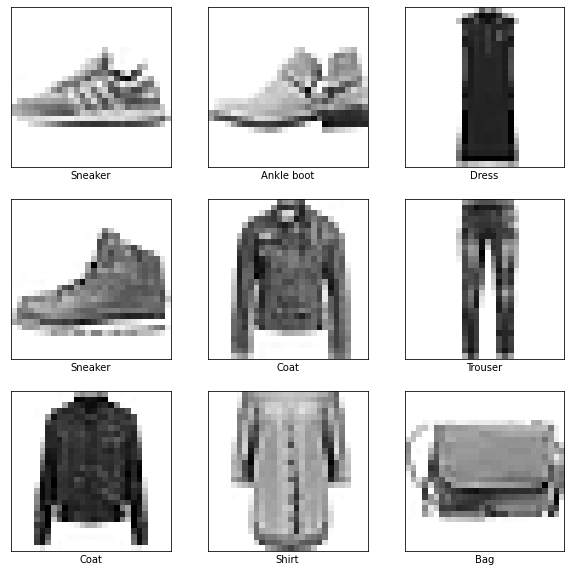

In [33]:
from numpy.random import randint
plt.figure(figsize=(10,10))

for idx, val in enumerate(randint(X_train.shape[0], size=9)):
    plt.subplot(3,3,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[val], cmap=plt.cm.binary)
    plt.xlabel(get_key(labels, y_train[val]))
plt.show()

* **2. Preprocesamiento los datos**

Tamaño original: (28, 28)
Nuevo tamaño: (24, 24)


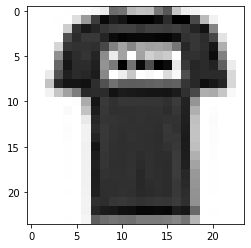

In [34]:
#pasamos las imágenes de 28 , 28 a ==> 24, 24
print(f'Tamaño original: {X_train[1].shape}')
def resize_image(img, new_size):
  """
  img = imagen a reescalar
  new_size = tupla (x, y) con el nuevo tamaño
  """
  res = cv.resize(img, new_size, interpolation = cv.INTER_CUBIC)
  return res

new_size = resize_image(X_train[1], (24, 24))
print(f'Nuevo tamaño: {new_size.shape}')

plt.imshow(new_size, cmap=plt.cm.binary)

**¿Por qué se tuvo que hacer un resize de las imágenes?**

Con el tamaño original 28 x 28 el auto encoder no retornaba al shape orginal sino que retornaba 32 x 32 esto debido a que:
8:45 05/05/2021
Alvaro Mauricio Montenegro Diaz: 
El problema es que si observa en su modelo, el encoder baja a la mitad de la dimensión de una capa a l a siguiente. Entonces el asunto va bien así en dimensiones: 28->14->7. Pero en el siguiente paso, como **7 no es par**,  el modelo transforma a tamaño 4!. El decoder no pude reajustar este tamaño.

Dos soluciones: 
1)  Cambiar el tamaño de la imágenes originales a 24x24. Así obtiene la reducción 24->12->6->3. Ahora el decoder si puede devolver bien las dimensiones.
2) Quitar una capa convolucional. Siempre se asegura que las reducciones se pueden devolver en tamaños.

En realidad puede haber otras soluciones.

Por favor nos cuenta que hizo

**En este caso se uso la solución 1.**

In [35]:
#resize de los datos de train
for i in range(0, X_train.shape[0]):
  new_size = resize_image(X_train[i], (24, 24))
  new_size = new_size[np.newaxis, :, :]
  #print(f'new_size{i}: {new_size.shape}')
  if i == 0:
    Xtrain_images = new_size.copy()
    #print(type(Xtrain_images))
    #print(f'first: {Xtrain_images.shape}')
  else:
    Xtrain_images = np.concatenate((Xtrain_images, new_size), axis=0)
    if i%5000 == 0:
      print(f'output{i}: {Xtrain_images.shape}')

Xtrain_images.shape

output5000: (5001, 24, 24)
output10000: (10001, 24, 24)
output15000: (15001, 24, 24)
output20000: (20001, 24, 24)
output25000: (25001, 24, 24)
output30000: (30001, 24, 24)
output35000: (35001, 24, 24)
output40000: (40001, 24, 24)
output45000: (45001, 24, 24)
output50000: (50001, 24, 24)
output55000: (55001, 24, 24)


(60000, 24, 24)

In [36]:
#resize de los datos de test
for i in range(0, X_test.shape[0]):
  new_size = resize_image(X_test[i], (24, 24))
  new_size = new_size[np.newaxis, :, :]
  #print(f'new_size{i}: {new_size.shape}')
  if i == 0:
    Xtest_images = new_size.copy()
    #print(type(Xtest_images))
    #print(f'first: {Xtest_images.shape}')
  else:
    Xtest_images = np.concatenate((Xtest_images, new_size), axis=0)
    if i%5000 == 0:
      print(f'output{i}: {Xtest_images.shape}')

Xtest_images.shape

output5000: (5001, 24, 24)


(10000, 24, 24)

In [37]:
# reshape para colocar los datos de entrenamiento en el fomato apropiado.
# Agrega una dimensión al final
train_images = Xtrain_images.reshape(60000, 24, 24, 1)
#normalizamos los px de las imagenes para que queden entre 0 y 1 
train_images = train_images/255.0

# reshape para colocar los datos de test en el fomato apropiado. Agrega una dimensión al final y  normaliza los datos
test_images = Xtest_images.reshape(10000, 24, 24, 1)
test_images = test_images/255.0

print("Nueva forma de los datos de train:", train_images.shape)
print("Nueva forma de los datos de test:", test_images.shape)

Nueva forma de los datos de train: (60000, 24, 24, 1)
Nueva forma de los datos de test: (10000, 24, 24, 1)


In [38]:
print(f'Imagenes (train) preprocesadas \nvalor minimo: {train_images[0].min()} \nvalor max: {train_images[0].max()}')

Imagenes (train) preprocesadas 
valor minimo: 0.0 
valor max: 1.0


* **4. Definimos la arquitectura del encoder**

* 4.1 reducción de tamaño con conv2D

para entender como las convoluciones cofican la información al reducir su tamaño definimos una función 

> $n$ = input shape $(n, n, n_c)$ *rows $n$, cols $n$, canales $n_c$*

> $p$ = padding donde $p = \frac{f - 1}{2}$

> $k$ = kernel shape $(k, k, k_c)$ *rows $k$, cols $k$, canales $k_c$*

> $s$ =  1 stride o salto por defecto (1, 1)

In [39]:
def shape_after_conv(imput_shape, kernel_shape, n_kernels, padding = 'valid', stride = 1):
  """
  Esta funcion retorna el tamaño de los datos despues de una 
  convolucion.

  inputs:
  imput_shape = tupla shape del dato no de los datos
  kernel_shape = tupla shape del kernel
  padding = el tipo de padding utilizado 'same' o 'valid' (default)
  stride = salto del kernel por defecto en layers.conv2D es 1 (default)
  n_kernels = cantidad de kernels en layers.conv2D

  output
  nuevo shape de los datos despues de una convolucion
  """
  n = imput_shape[1]
  if padding == 'same':
    p = (kernel_shape[0] - 1)/2
  else:
    p = 0
  k = kernel_shape[0]
  s = stride
  floor = lambda n, p, k, s:  ((n + 2*p - k)/s) + 1
  shape_conv = (floor(n, p, k, s), floor(n, p, k, s), n_kernels)
  
  return shape_conv

In [40]:
#en esta celda exploramos como se contrae la informacion dependiendo de los parametros de la convolucion
input = (28, 28, 1)
filters = [4, 16, 32, 64] #Estos filtros van en potencias de dos 2**2 = 4, 2**4 = 16, 2**5 = 32, 2**6 =64
for i, filter in enumerate(filters):
  input = shape_after_conv(input, (3, 3), filter, stride=2, padding= 'valid')
  print(f'output conv{i+1}: {input}') #salen sin redondear

output conv1: (13.5, 13.5, 4)
output conv2: (6.25, 6.25, 16)
output conv3: (2.625, 2.625, 32)
output conv4: (0.8125, 0.8125, 64)


output inputs: (None, 24, 24, 1)
output conv1: (None, 12, 12, 4)
output conv2: (None, 6, 6, 16)
output conv3: (None, 3, 3, 32)
output conv3: (None, 3, 3, 32)
output flat: (None, 288)
output dense: (None, 32)
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 24, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 4)         40        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 16)          592       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
_________________________________________________

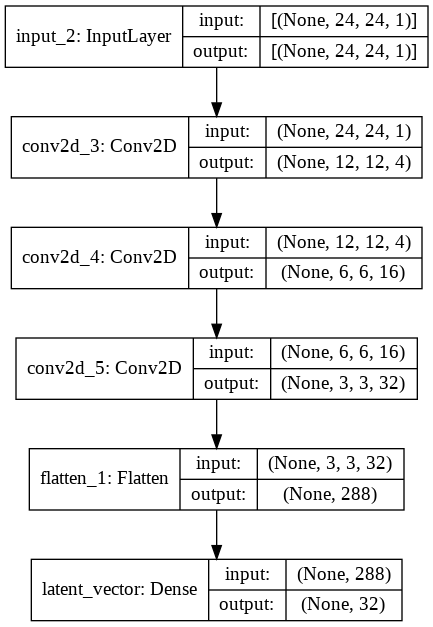

In [41]:
from tensorflow.keras.models import Model
from keras import layers, Input
from tensorflow.keras import utils

inputs = Input(shape =(24, 24, 1)) 
print(f'output inputs: {inputs.shape}')
#encoder
#input = 28 x 28 x 1 (wide and thin)
conv1 = layers.Conv2D(4, (3, 3), activation='relu', strides=(2,2),padding='same')(inputs) 
print(f'output conv1: {conv1.shape}') #(None, 24, 24, 1)
conv2 = layers.Conv2D(16, (3, 3), activation='relu', strides=(2,2),padding='same')(conv1)
print(f'output conv2: {conv2.shape}') #(None, 12, 12, 4)
conv3 = layers.Conv2D(32, (3, 3), activation='relu', strides=(2,2),padding='same')(conv2)
print(f'output conv3: {conv3.shape}') #(None, 3, 3, 32)
#conv4 = layers.Conv2D(64, (3, 3), activation='relu', strides=(2,2),padding='same')(conv3) #2 x 2 x 64

# Save the shape to the decoder
shape = conv3.shape#.as_list()
print(f'output conv3: {shape}') #(None, 2, 2, 64)
flat = layers.Flatten()(conv3)
print(f'output flat: {flat.shape}') #(None, 256

encoded = layers.Dense(shape[-1], name ='latent_vector')(flat) 
print(f'output dense: {encoded.shape}')
encoder = Model(inputs, encoded, name ='encoder')

encoder.summary()
utils.plot_model(encoder, show_shapes=True) 

* **5. Definimos la arquitectura del decoder**

output input: (None, 32)
output dense2: (None, 288)
output dense2 reshape: (None, 3, 3, 32)
output conv1_dec: (None, 6, 6, 16)
output conv2_dec: (None, 12, 12, 4)
output conv4_dec: (None, 24, 24, 1)
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 288)               9504      
_________________________________________________________________
reshape_1 (Reshape)          (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 6, 6, 16)          4624      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 12, 12, 4)         580       
__________________________________________________________

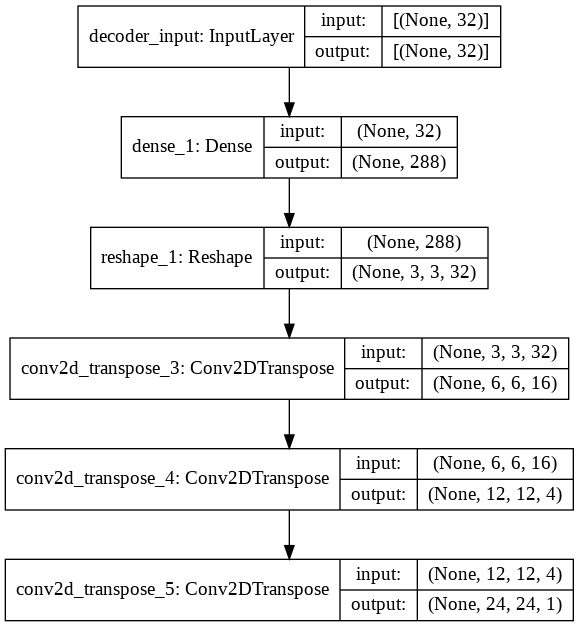

In [42]:
 
#decoder
encoded_inputs = Input(shape =(shape[-1],), name ='decoder_input') # (None, 64)
print(f'output input: {encoded_inputs.shape}')
latent_dec = layers.Dense(np.prod(shape[1:]))(encoded_inputs) # (None, 256)
print(f'output dense2: {latent_dec.shape}') 
reshape_dec = layers.Reshape((shape[1], shape[2], shape[3]))(latent_dec) # (None, 2, 2, 64)
print(f'output dense2 reshape: {reshape_dec.shape}')
conv1_dec = layers.Conv2DTranspose(16, (3, 3), activation='relu', strides=(2,2),padding='same')(reshape_dec) # (None, 4, 4, 32)
print(f'output conv1_dec: {conv1_dec.shape}')
conv2_dec = layers.Conv2DTranspose(4, (3, 3), activation='relu', strides=(2,2),padding='same')(conv1_dec) # (None, 8, 8, 16)
print(f'output conv2_dec: {conv2_dec.shape}')
#maxpool = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(conv2_dec) # (None, 7, 7, 16)
#print(f'output maxpool: {maxpool.shape}')
#conv3_dec = layers.Conv2DTranspose(4, (3, 3), activation='relu', strides=(2,2),padding='same')(conv2_dec) # (None, 14, 14, 4)
#print(f'output conv3_dec: {conv3_dec.shape}')
decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', strides=(2,2),padding='same')(conv2_dec) # (None, 28, 28, 1)
print(f'output conv4_dec: {decoded.shape}')
decoder = Model(encoded_inputs, decoded, name ='decoder')

decoder.summary()
utils.plot_model(decoder, show_shapes=True)






* **6. Compilamos el modelo**

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 24, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 32)                14520     
_________________________________________________________________
decoder (Functional)         (None, 24, 24, 1)         14745     
Total params: 29,265
Trainable params: 29,265
Non-trainable params: 0
_________________________________________________________________


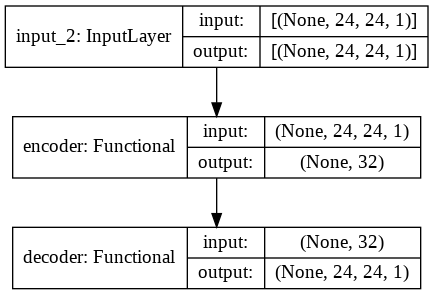

In [43]:
from tensorflow.keras import utils


#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
autoencoder = Model(inputs, decoder(encoder(inputs)))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy', 'mse'])

autoencoder.summary()
utils.plot_model(autoencoder, show_shapes=True)

In [44]:
history = autoencoder.fit(train_images, train_images, batch_size=128, epochs=50, shuffle=True, validation_data=(test_images,test_images))

Epoch 1/50
469/469 [==============================] - 10s 20ms/step - loss: 0.0890 - accuracy: 0.4311 - mse: 0.0890 - val_loss: 0.0211 - val_accuracy: 0.4563 - val_mse: 0.0211
Epoch 2/50
469/469 [==============================] - 9s 20ms/step - loss: 0.0196 - accuracy: 0.4578 - mse: 0.0196 - val_loss: 0.0165 - val_accuracy: 0.4573 - val_mse: 0.0165
Epoch 3/50
469/469 [==============================] - 9s 20ms/step - loss: 0.0157 - accuracy: 0.4604 - mse: 0.0157 - val_loss: 0.0142 - val_accuracy: 0.4578 - val_mse: 0.0142
Epoch 4/50
469/469 [==============================] - 9s 20ms/step - loss: 0.0137 - accuracy: 0.4599 - mse: 0.0137 - val_loss: 0.0129 - val_accuracy: 0.4581 - val_mse: 0.0129
Epoch 5/50
469/469 [==============================] - 9s 20ms/step - loss: 0.0125 - accuracy: 0.4601 - mse: 0.0125 - val_loss: 0.0121 - val_accuracy: 0.4582 - val_mse: 0.0121
Epoch 6/50
469/469 [==============================] - 9s 19ms/step - loss: 0.0117 - accuracy: 0.4609 - mse: 0.0117 - val_los

In [45]:
#entrenamiento con GPU
import timeit

def entrenamiento_gpu():
  with tf.device('/device:GPU:0'):
    #especificamos que se use la GPU
    history = autoencoder.fit(train_images, train_images, validation_data=(test_images,test_images), batch_size=256, epochs=50, verbose=1)
  
  return history

gpu_time = timeit.timeit('entrenamiento_gpu()', number=1, setup='from __main__ import entrenamiento_gpu')

Epoch 1/50
235/235 [==============================] - 8s 32ms/step - loss: 0.0077 - accuracy: 0.4609 - mse: 0.0077 - val_loss: 0.0078 - val_accuracy: 0.4587 - val_mse: 0.0078
Epoch 2/50
235/235 [==============================] - 7s 32ms/step - loss: 0.0077 - accuracy: 0.4609 - mse: 0.0077 - val_loss: 0.0077 - val_accuracy: 0.4587 - val_mse: 0.0077
Epoch 3/50
235/235 [==============================] - 8s 32ms/step - loss: 0.0076 - accuracy: 0.4609 - mse: 0.0076 - val_loss: 0.0078 - val_accuracy: 0.4587 - val_mse: 0.0078
Epoch 4/50
235/235 [==============================] - 7s 32ms/step - loss: 0.0076 - accuracy: 0.4609 - mse: 0.0076 - val_loss: 0.0077 - val_accuracy: 0.4587 - val_mse: 0.0077
Epoch 5/50
235/235 [==============================] - 8s 32ms/step - loss: 0.0076 - accuracy: 0.4609 - mse: 0.0076 - val_loss: 0.0078 - val_accuracy: 0.4587 - val_mse: 0.0078
Epoch 6/50
235/235 [==============================] - 8s 32ms/step - loss: 0.0076 - accuracy: 0.4609 - mse: 0.0076 - val_loss

* **7. Evaluación**

In [46]:
autoencoder.evaluate(test_images,test_images)

313/313 [==============================] - 1s 3ms/step - loss: 0.0075 - accuracy: 0.4588 - mse: 0.0075


[0.0074797216802835464, 0.45876023173332214, 0.007479724939912558]

* **8. Guardamos el modelo entrenado y evaluado**

In [47]:
autoencoder.save('./Autoencoder_FashionMINIST.h5') #guardamos el modelo entrenado y evaluado

In [48]:
#para cargamos nuestro modelo entrenado y evaluado
from tensorflow.keras.models import load_model

autoencoder = load_model('/content/Autoencoder_FashionMINIST.h5')

* **9. Predicciones**



In [49]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,mse,val_loss,val_accuracy,val_mse,epoch
45,0.007810,0.460902,0.007810,0.007875,0.458718,0.007875,45
46,0.007789,0.460904,0.007789,0.007874,0.458728,0.007874,46
47,0.007772,0.460905,0.007772,0.007897,0.458687,0.007897,47
48,0.007753,0.460907,0.007753,0.007855,0.458731,0.007855,48
49,0.007738,0.460908,0.007738,0.007842,0.458711,0.007842,49


* **10. Evaluación del modelo**

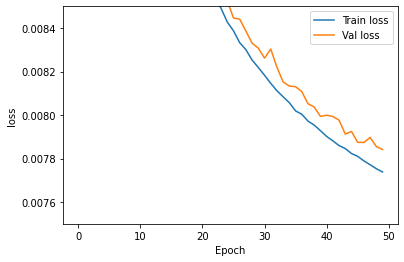

In [50]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')
  plt.ylim([0.0075,0.0085])
  plt.legend()

  plt.show()


plot_history(history)

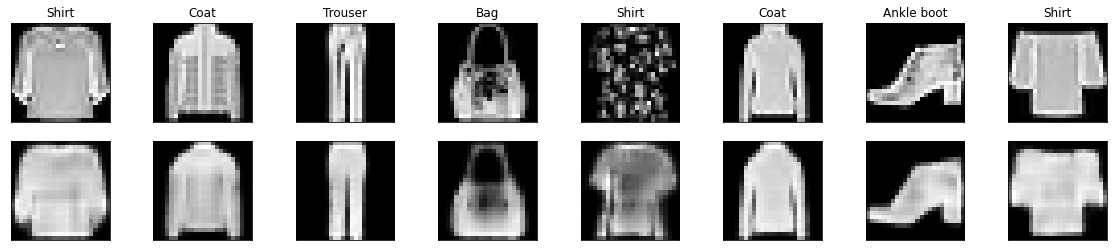

In [55]:
decoded_imgs = autoencoder.predict(test_images)
n = 10
plt.figure(figsize=(20, 4))
for i, num in enumerate(randint(test_images.shape[0], size=8)): 
    # Display original
    ax = plt.subplot(2, 8, i+1)
    plt.imshow(test_images[num].reshape(24, 24))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(get_key(labels, y_test[num]))

    # Display reconstruction
    ax = plt.subplot(2, 8, i+9)
    plt.imshow(decoded_imgs[num].reshape(24, 24))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Con este codigo se puede generar nuevas prendas de vestir

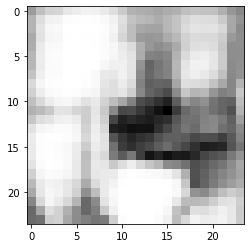

In [102]:
g = tf.random.Generator.from_non_deterministic_state()
#esta funcion es un generador inicializando su estado de forma no determinista.
random_latent_space = g.normal(shape=(1, 32))
ropa_random = decoder(random_latent_space)
imagen_ropa_random = tf.reshape(ropa_random, [24,24])
plt.imshow(imagen_ropa_random, cmap=plt.cm.binary)

espacio latente

In [66]:
encoded_images_test = encoder(test_images)

In [79]:
encoded_images_test

<tf.Tensor: shape=(10000, 32), dtype=float32, numpy=
array([[ -2.9107156 ,   2.2005036 ,  -1.7878087 , ...,   0.8358246 ,
         -1.5213385 ,   2.9681306 ],
       [  0.8878804 ,  -2.0735607 , -10.3982115 , ...,  -0.8794638 ,
          4.9908657 ,  -4.0019183 ],
       [ -2.421937  ,  -2.9240394 ,  -3.0542102 , ...,   0.77115285,
          2.260231  ,   5.1159782 ],
       ...,
       [  2.479601  ,   2.646494  ,  -6.57945   , ...,  -1.2502873 ,
         -1.9003378 ,   0.43289712],
       [ -5.002645  ,   0.2870811 ,   0.92226386, ...,  -0.2633274 ,
          1.876097  ,   4.2996535 ],
       [ -2.7164674 ,   0.50644296,  -0.60411286, ...,  -0.53232455,
         -0.24944569,   2.7322671 ]], dtype=float32)>

In [81]:
test_images_labels = [get_key(labels, num) for num in y_test]

test_images_labels[0:10] #primeras 10


['Ankle boot',
 'Pullover',
 'Trouser',
 'Trouser',
 'Shirt',
 'Trouser',
 'Coat',
 'Shirt',
 'Sandal',
 'Sneaker']